In [ ]:
#https://github.com/eriklindernoren/Keras-GAN/blob/master/cyclegan/cyclegan.py

#참고하였음.
#dataset 주소

#https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/


In [1]:
import pandas as pd
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.layers import BatchNormalization

C:\Users\ie-46\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:

#from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [4]:
trainA_dir = "./monet2photo/trainA/*.jpg"
trainB_dir = "./monet2photo/trainB/*.jpg"
testA_dir = "./monet2photo/testA/*.jpg"
testB_dir = "./monet2photo/testB/*.jpg"

In [15]:
class CycleGAN:
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
    
        self.generator_filter = 32
        self.discriminator_filter = 64
        
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)
        self.lambda_cycle = 10.0     
        self.lambda_id = 0.1 * self.lambda_cycle
        
        self.optimizer = Adam(0.0002, 0.5)
        
            
        
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        

        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()
        
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)
        
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)
        

        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)
            
        self.d_A.trainable = False
        self.d_B.trainable = False
        
        self.cyclegan = Model(inputs  = [img_A,img_B],outputs = [valid_A,valid_B,\
                                                               reconstr_A,reconstr_B,\
                                                               img_A_id,img_B_id])
        self.cyclegan.compile(loss=['mse','mse','mae','mae','mae','mae'],optimizer =\
                             self.optimizer,loss_weights= [1,1,self.lambda_cycle,\
                                                          self.lambda_cycle,\
                                                          self.lambda_id, self.lambda_id] )
        self.d_A.trainable = True
        self.d_B.trainable = True
        
        self.d_A.compile(loss = 'mse', optimizer = self.optimizer ,metrics = ['accuracy'])
        self.d_B.compile(loss = 'mse', optimizer = self.optimizer ,metrics = ['accuracy'])
    
        
    
    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = BatchNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.discriminator_filter, normalization=False)
        d2 = d_layer(d1, self.discriminator_filter*2)
        d3 = d_layer(d2, self.discriminator_filter*4)
        d4 = d_layer(d3, self.discriminator_filter*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)
    
    def build_generator(self):
        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = BatchNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

            # Downsampling
        d1 = conv2d(d0, self.generator_filter)
        d2 = conv2d(d1, self.generator_filter*2)
        d3 = conv2d(d2, self.generator_filter*4)
        d4 = conv2d(d3, self.generator_filter*8)

            # Upsampling
        u1 = deconv2d(d4, d3, self.generator_filter*4)
        u2 = deconv2d(u1, d2, self.generator_filter*2)
        u3 = deconv2d(u2, d1, self.generator_filter)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)
        
        return Model(d0, output_img)
    
    def train(self, epochs, batch_size = 1):
    
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        trainA = self.image_name(trainA_dir)
        trainB = self.image_name(trainB_dir)
        for epoch in range(epochs):
            train_len = len(trainA)
            
            for i in range(train_len):
                imgs_A = self.image_loading(trainA[i])
                imgs_B = self.image_loading(trainB[i])
            
                
                fake_B = self.g_AB.predict(imgs_A)
                #print("fake_B")
                fake_A = self.g_BA.predict(imgs_B)
                #print("fake_A")
                
                self.d_A.train_on_batch(imgs_A,valid)
                #print("d_A train valid")
                self.d_A.train_on_batch(fake_A, fake)
                #print("d_A train fake")
                
                self.d_B.train_on_batch(imgs_B,valid)
                #print("d_B train valid")
                self.d_B.train_on_batch(fake_B, fake)
                #print("d_B train fake")
                
                self.cyclegan.train_on_batch([imgs_A,imgs_B],\
                                            [valid,valid,\
                                            imgs_A, imgs_B,\
                                            imgs_A, imgs_B])
                
                print(i,"/", train_len)
            print(epoch,"/",epochs)
            
    def output(self,num = 0, name=''):
        r,c = 2,3
        testA = self.image_name(testA_dir)
        testB = self.image_name(testB_dir)
        imgs_A = self.image_loading(testA[num])
        imgs_B = self.image_loading(testB[num])
        
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)
        
        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])
        
        #print(imgs_A)
        #print("***********")
        #print(gen_imgs)
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        #print("***********")
        #print(gen_imgs)
        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        if name != '':
            fig.savefig(name)
            plt.close()
    def image_name(self,file_place):
        file_names = glob.glob(file_place)
        return file_names
    
    def image_loading(self,im_name):
        im = Image.open(im_name).convert('RGB')
        im = im.resize((self.img_rows,self.img_cols),Image.BILINEAR)
        im = np.array(im)
        im = im.reshape((-1,self.img_rows,self.img_cols,self.channels))
        im = im-127.5
        im = im/127.5
        return im

cyclegan_model = CycleGAN()
        

In [16]:
cyclegan_model.d_A.load_weights("monet_d_A_model.h5")
cyclegan_model.d_B.load_weights("monet_d_B_model.h5")
cyclegan_model.g_AB.load_weights("monet_g_AB_Amodel.h5")
cyclegan_model.g_BA.load_weights("monet_g_BA_Amodel.h5")
cyclegan_model.cyclegan.load_weights("monet_cyclegan_model.h5")

In [10]:
cyclegan_model.output(num=1,name='asdsd.png')

In [17]:
for i in range(50):
    cyclegan_model.train(epochs=1)
    cyclegan_model.d_A.save_weights("monet_d_A_model.h5")
    cyclegan_model.d_B.save_weights("monet_d_B_model.h5")
    cyclegan_model.g_AB.save_weights("monet_g_AB_Amodel.h5")
    cyclegan_model.g_BA.save_weights("monet_g_BA_Amodel.h5")
    cyclegan_model.cyclegan.save_weights("monet_cyclegan_model.h5")
    for j in range(100):
        file_name ='monet_'+ str(i)+ '_epochs_' + str(j) + 'th_file.png'
        cyclegan_model.output(num=j,name=file_name)

C:\Users\ie-46\Anaconda3\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: 

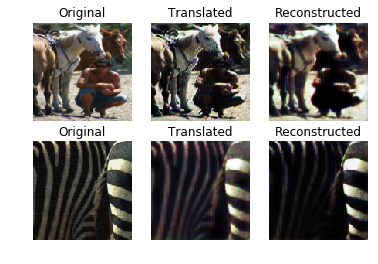

In [48]:
cyclegan_model.output(num=90)